In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10     
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
import glob   
import cv2  
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
!pip install opencv-python

In [4]:
image = cv2.imread('/kaggle/input/alzheimer-mri-dataset/Dataset/Non_Demented/non.jpg')

In [4]:
image.shape

(128, 128, 3)

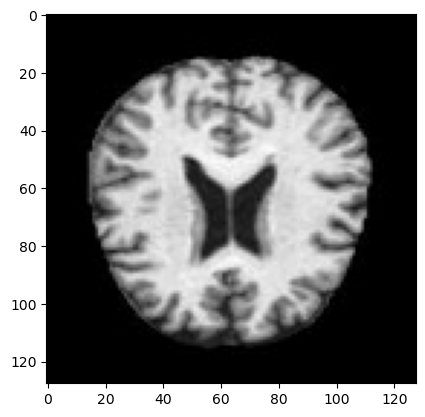

In [5]:
plt.imshow(image) 

In [5]:
import glob
import librosa     
import numpy as np
import cv2 
mild_demented = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Mild_Demented/*.jpg')
moderate_demented = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Moderate_Demented/*.jpg')
non_demented = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Non_Demented/*.jpg')
very_mild_demented = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Very_Mild_Demented/*.jpg')

data = []  
labels = []

image_size=(224,224)  

for i in mild_demented:   
    image = cv2.imread(i)
    # Resize the image
    image = cv2.resize(image, image_size)

    data.append(image)
    labels.append(0)     

for i in moderate_demented:   
    image = cv2.imread(i)
    # Resize the image
    image = cv2.resize(image, image_size)

    data.append(image)
    labels.append(1)
    
for i in non_demented:   
    image = cv2.imread(i)
    # Resize the image
    image = cv2.resize(image, image_size)

    data.append(image)
    labels.append(2)
    
for i in very_mild_demented:   
    image = cv2.imread(i)
    # Resize the image
    image = cv2.resize(image, image_size)

    data.append(image)
    labels.append(3)

X=np.array(data)  
y=np.array(labels) 
print(y.shape) 

unique_labels = np.unique(y)

for label in unique_labels:
    label_indices = np.where(y == label)[0]
    label_shape = label_indices.shape
    print(f"Label {label}: Shape = {label_shape}")

(6400,)
Label 0: Shape = (896,)
Label 1: Shape = (64,)
Label 2: Shape = (3200,)
Label 3: Shape = (2240,)


In [6]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Perform train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=32)

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D,Add, BatchNormalization, MaxPooling2D, Flatten, Dense,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the input shape
input_shape = (224, 224, 3)

# Define the input tensor
inputs = Input(shape=input_shape)

# For 64 filter size convolutional layer

x = Conv2D(64, (7, 7), strides=(2, 2), padding='same',activation='relu')(inputs)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
res=x

# For rest of the convolutional layer

for i in np.arange(0,3):
    x = Conv2D(64, (3, 3), padding='same',activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x=Add()([x,res])
    x=Activation('relu')(x)
    res=x
    
D=[3,5,2]
for i in np.arange(0,3):
    mul=2**(i+1)
    x = Conv2D(mul*64, (3, 3), strides=(2, 2),padding='same',activation='relu')(x)
    x = Conv2D(mul*64, (3, 3), padding='same')(x)
    res=Conv2D(mul*64,(1,1),strides=(2,2))(res)
    x=Add()([x,res])
    x=Activation('relu')(x)
    res=x


    for j in np.arange(0,D[i]):
        x = Conv2D(mul*64, (3, 3), padding='same',activation='relu')(x)
        x = Conv2D(mul*64, (3, 3), padding='same')(x)
        x=Add()([x,res])
        x=Activation('relu')(x)
        res=x
    
x=Flatten()(x)

Dense(254,activation='relu')
Dense(150,activation='relu')
Dense(50,activation='relu')

# Output layer
outputs = Dense(4, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.1,          
    patience=5,            
    min_lr=1e-6 )          

# Define the model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Define the early stopping callback to stop training if validation loss does not improve
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with the learning rate reduction callback
history= model.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=10, batch_size=32,callbacks=[lr_callback,checkpoint_callback,early_stopping_callback])

# Evaluate the model
best_model = tf.keras.models.load_model('best_model.h5')
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_73 (Conv2D)             (None, 112, 112, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 56, 56, 64)  0           ['conv2d_73[0][0]']              
                                                                                            

40/40 [==============================] - 1s 26ms/step
Classification Report:
                     precision    recall  f1-score   support

     mild_demented       0.53      0.50      0.51       177
 moderate_demented       1.00      0.25      0.40        12
      non_demented       0.73      0.84      0.79       648
very_mild_demented       0.64      0.53      0.58       443

          accuracy                           0.68      1280
         macro avg       0.73      0.53      0.57      1280
      weighted avg       0.67      0.68      0.67      1280



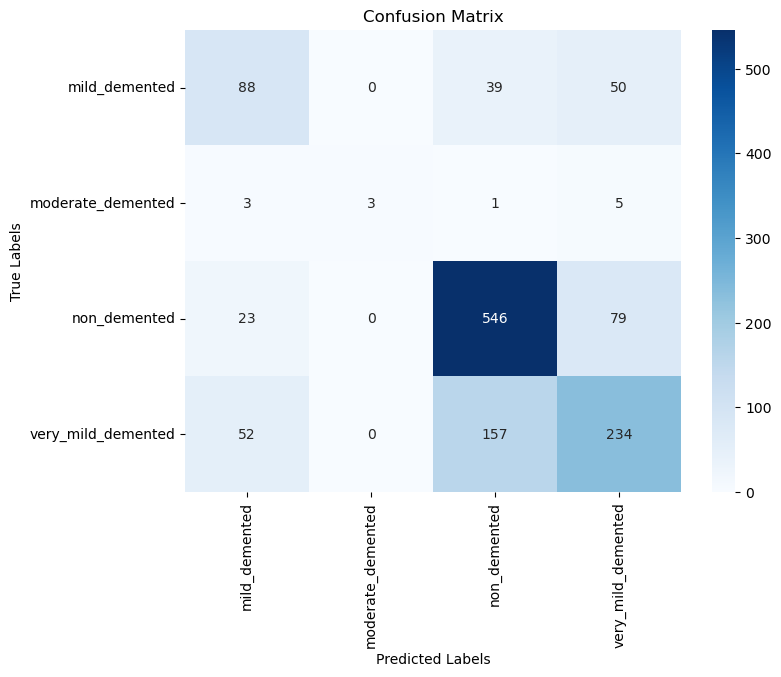

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


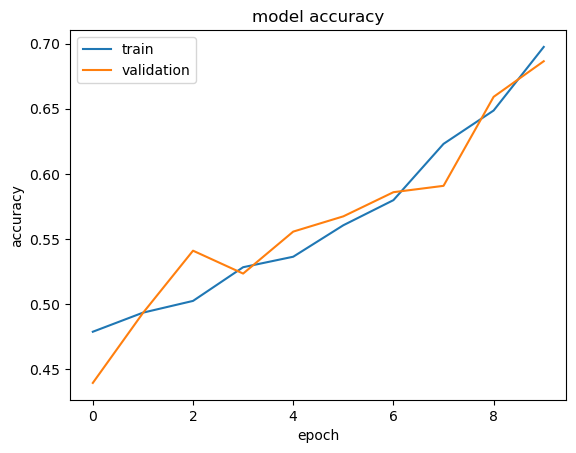

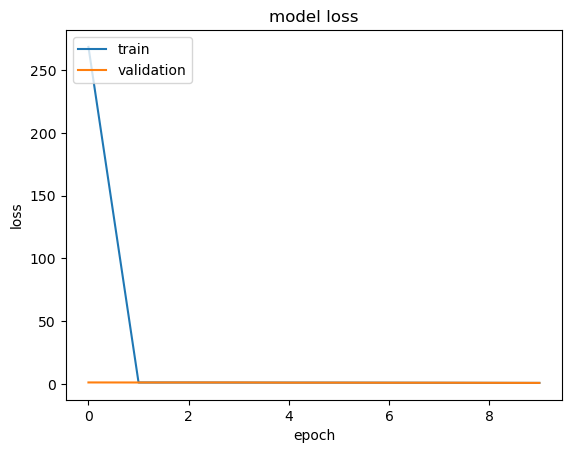

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Generate the classification report
class_names = list(['mild_demented','moderate_demented','non_demented','very_mild_demented'])
report = classification_report(y_test, predicted_classes , target_names=class_names)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_classes )
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# The annot=True argument displays the values inside the heatmap cells. 
#fmt="d" specifies that the values should be displayed as integers. 
#The cmap="Blues" argument sets the color map to shades of blue.
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
